In [ ]:
%pip install tensorflow --quiet

import numpy as np
from tensorflow.keras.datasets import mnist

# Parámetros
n_samples = 10_000
val_ratio = 0.1
test_ratio = 0.1

# Cargar MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()  # (N, 28, 28)

images = np.concatenate([x_train, x_test], axis=0)
labels = np.concatenate([y_train, y_test], axis=0).squeeze()

# Limitar y barajar
n_samples = min(n_samples, images.shape[0])
images = images[:n_samples]
labels = labels[:n_samples]
rng = np.random.default_rng(seed=42)
perm = rng.permutation(n_samples)
images = images[perm].astype(np.float32) / 255.0  # normaliza [0,1]
labels = labels[perm]

# Splits
n_val = int(val_ratio * n_samples)
n_test = int(test_ratio * n_samples)
n_train = n_samples - n_val - n_test

x_train_split = images[:n_train]
y_train_split = labels[:n_train]
x_val_split   = images[n_train:n_train + n_val]
y_val_split   = labels[n_train:n_train + n_val]
x_test_split  = images[n_train + n_val:]
y_test_split  = labels[n_train + n_val:]

print(f"Total: {n_samples} | Train: {len(x_train_split)} | Val: {len(x_val_split)} | Test: {len(x_test_split)}")
print("Shapes:", x_train_split.shape, x_val_split.shape, x_test_split.shape)


Total: 10000 | Train: 8000 | Val: 1000 | Test: 1000
Shapes: (8000, 28, 28) (1000, 28, 28) (1000, 28, 28)


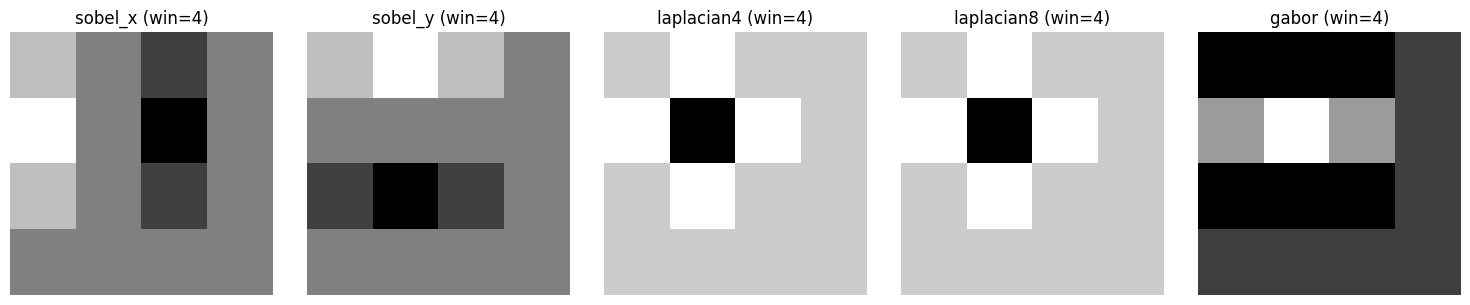

In [4]:
import matplotlib.pyplot as plt
from src.utils import build_kernel_patch

# Configuración
win = 4  # pon 4 u 8
gabor_params = {"theta": 0.0, "sigma": win/4, "freq": 0.25, "size": win-1 if win%2==0 else win}

kernel_specs = [
    ("sobel_x", {}),
    ("sobel_y", {}),
    ("laplacian4", {}),
    ("laplacian8", {}),
    ("gabor", gabor_params),
]

patches = [(name, build_kernel_patch(name, win, **params)) for name, params in kernel_specs]

plt.figure(figsize=(3*len(patches), 3))
for i, (name, kp) in enumerate(patches, 1):
    plt.subplot(1, len(patches), i)
    plt.imshow(kp, cmap="gray")
    plt.title(f"{name} (win={win})")
    plt.axis("off")
plt.tight_layout()
plt.show()


d:\Documents\GitHub\x-FRQI\goq\Lib\site-packages\pennylane\devices\device_api.py:193: PennyLaneDeprecationWarning: Setting shots on device is deprecated. Please use the `set_shots` transform on the respective QNode instead.
  warnings.warn(


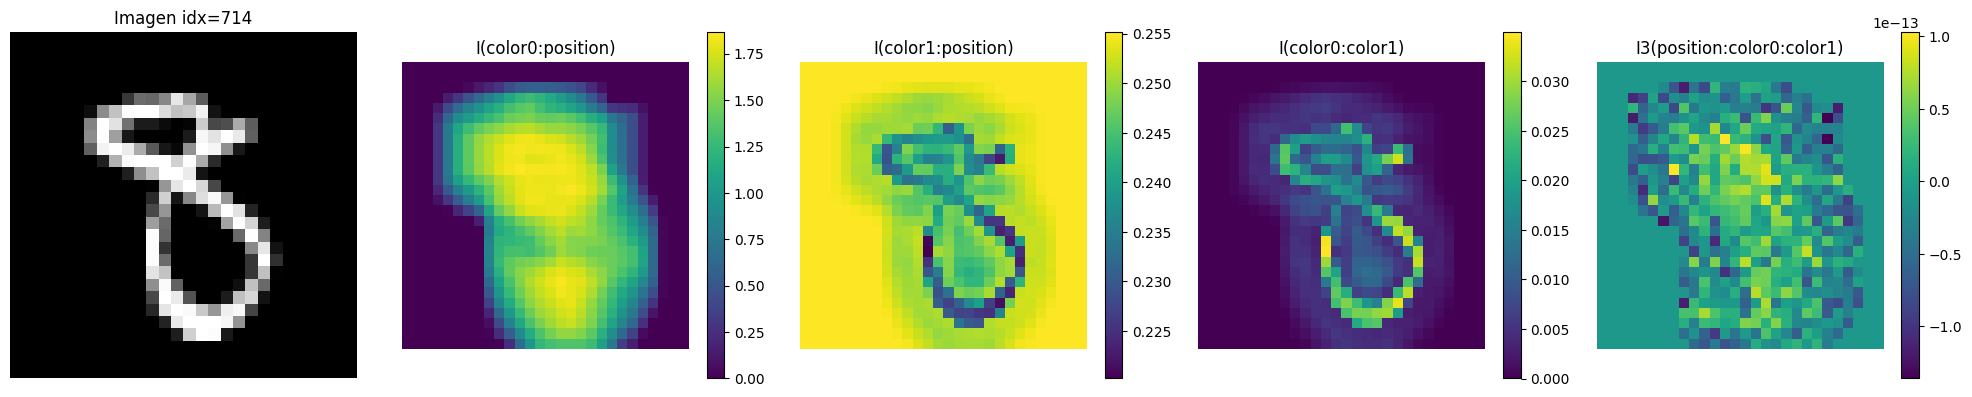

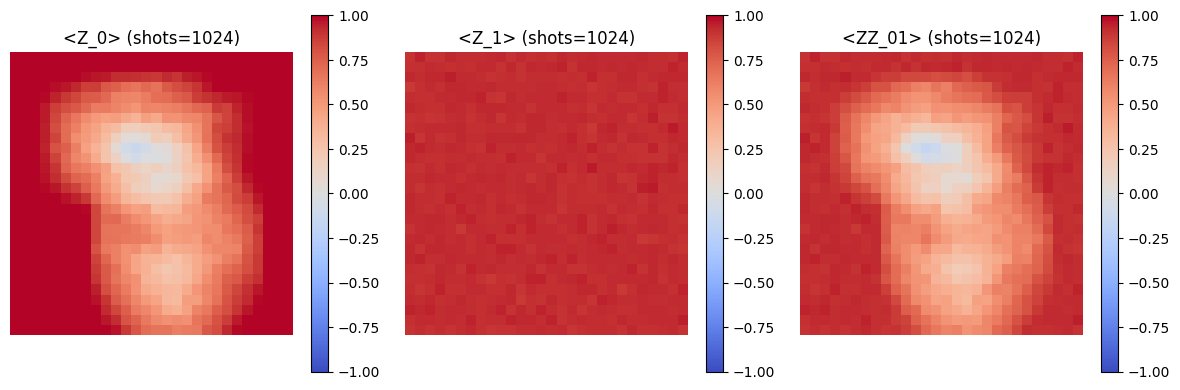

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from src import FRQI2
from src.utils import ensure_uint8, build_kernel_patch

# --- Configuración ---
win = 8                      # ventana (4 u 8)
kernel_name = "laplacian4"   # sobel_x, sobel_y, laplacian4, laplacian8, gabor
pad_mode = "reflect"
shots = 1024                 # >0 para muestreo en Z; None para analítico
rng = np.random.default_rng(42)
idx = rng.integers(0, len(x_train_split))  # imagen aleatoria

# --- Imagen y kernel ---
img = x_train_split[idx]               # (28,28) float [0,1]
img_u8 = ensure_uint8(img * 255.0)
H, W = img_u8.shape
pad = win // 2
padded = np.pad(img_u8, pad, mode=pad_mode)

kpatch_u8 = build_kernel_patch(kernel_name, win)  # centra/normaliza según win

# --- Barrido completo ---
feature_maps = {}
zz_maps = {}  # para color_Z_stats: <Z_0>, <Z_1>, <ZZ_01>
model = FRQI2(image_size=win, device="default.qubit")  # usa lightning.qubit si lo tienes

for m in ["H_total", "H_position", "H_color0", "H_color1",
          "I(color0:position)", "I(color1:position)",
          "H_color0|position", "H_color1|position",
          "H_colors_joint", "I(color0:color1)", "H_color0|color1", "H_color1|color0",
          "I3(position:color0:color1)"]:
    feature_maps[m] = np.full((H, W), np.nan, dtype=float)

for m in ["<Z_0>", "<Z_1>", "<ZZ_01>"]:
    zz_maps[m] = np.full((H, W), np.nan, dtype=float)

for i in range(H):
    for j in range(W):
        p0 = padded[i:i+win, j:j+win]
        state = model.encode(p0, kpatch_u8)
        info = model.analyze_state(state)
        for m in feature_maps:
            if m in info:
                feature_maps[m][i, j] = info[m]
        # mediciones en Z (expval o muestreo)
        z_stats = model.color_Z_stats(p0, kpatch_u8, shots=shots, backend=None)
        for m in zz_maps:
            if m in z_stats:
                zz_maps[m][i, j] = z_stats[m]

# --- Visualización de algunas métricas ---
maps_to_show = ["I(color0:position)", "I(color1:position)", "I(color0:color1)", "I3(position:color0:color1)"]
zz_to_show = ["<Z_0>", "<Z_1>", "<ZZ_01>"]

plt.figure(figsize=(4*(1+len(maps_to_show)), 4))
plt.subplot(1, len(maps_to_show)+1, 1)
plt.imshow(img_u8, cmap="gray"); plt.title(f"Imagen idx={idx}"); plt.axis("off")
for k, m in enumerate(maps_to_show, start=2):
    plt.subplot(1, len(maps_to_show)+1, k)
    plt.imshow(feature_maps[m], cmap="viridis")
    plt.title(m); plt.axis("off"); plt.colorbar()
plt.tight_layout(); plt.show()

plt.figure(figsize=(4*len(zz_to_show), 4))
for k, m in enumerate(zz_to_show, start=1):
    plt.subplot(1, len(zz_to_show), k)
    plt.imshow(zz_maps[m], cmap="coolwarm", vmin=-1, vmax=1)
    plt.title(m + f" (shots={shots})"); plt.axis("off"); plt.colorbar()
plt.tight_layout(); plt.show()


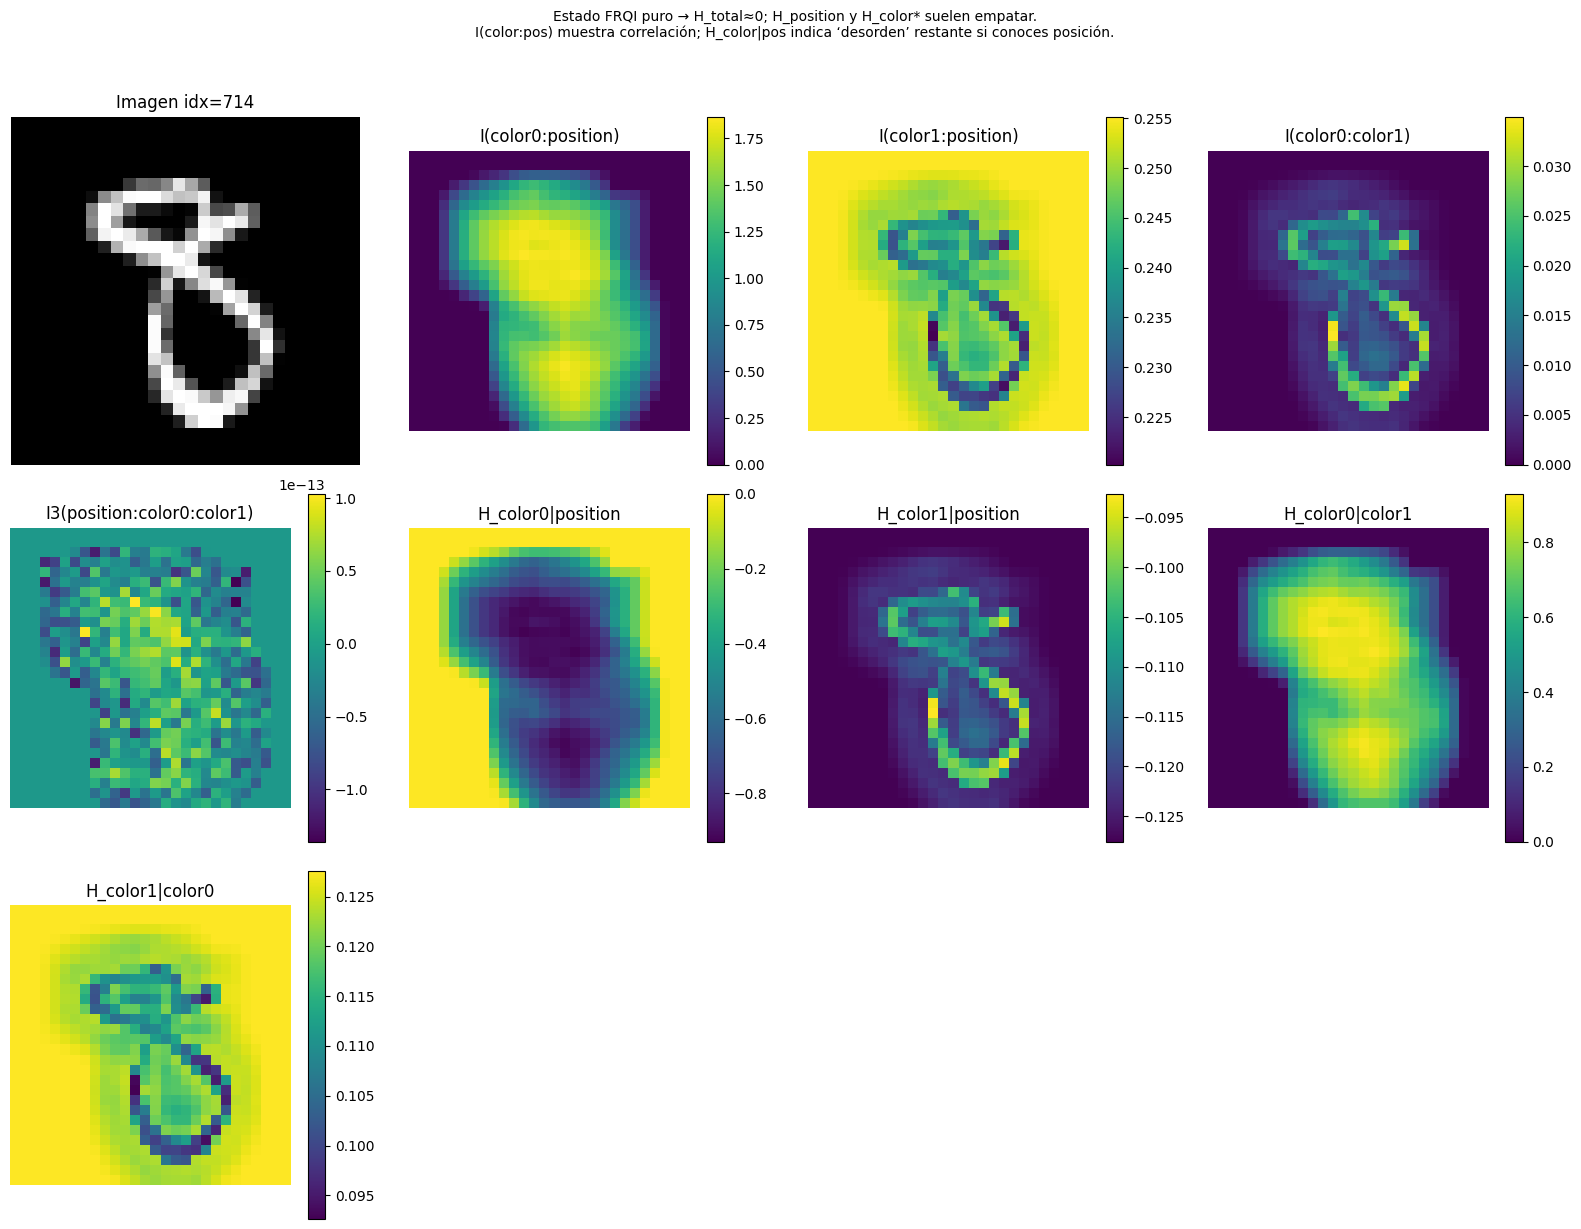

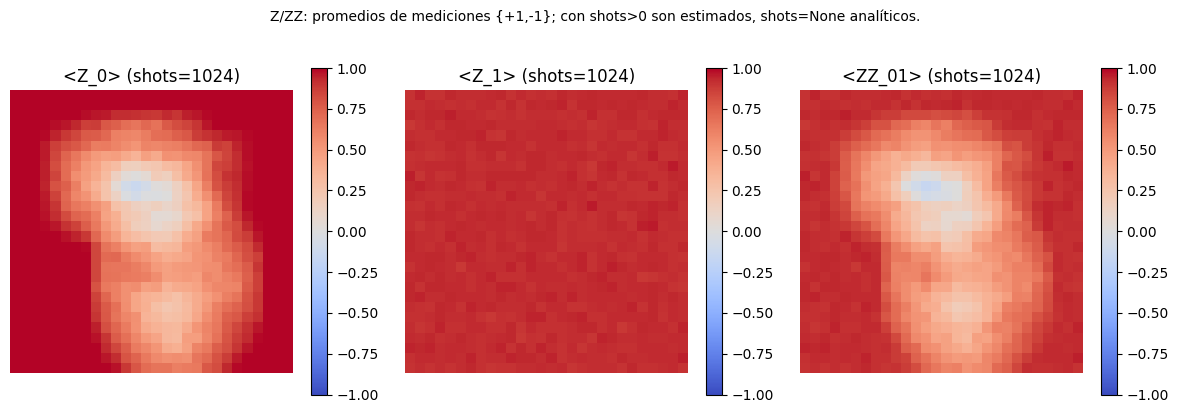

In [10]:
def show_maps(img_u8, feature_maps, zz_maps, idx, shots, cols=4):
    maps_to_show = [
        "I(color0:position)", "I(color1:position)",
        "I(color0:color1)", "I3(position:color0:color1)",
        "H_color0|position", "H_color1|position",
        "H_color0|color1", "H_color1|color0",
    ]
    zz_to_show = ["<Z_0>", "<Z_1>", "<ZZ_01>"]

    # ensure the grid has room for the image + all maps
    total_panels = 1 + len(maps_to_show)  # 1 for the image
    rows = int(np.ceil(total_panels / cols))
    plt.figure(figsize=(4*cols, 4*rows))
    plt.subplot(rows, cols, 1)
    plt.imshow(img_u8, cmap="gray"); plt.title(f"Imagen idx={idx}"); plt.axis("off")
    for k, m in enumerate(maps_to_show, start=2):
        # k runs from 2 .. total_panels, which fits in rows*cols
        plt.subplot(rows, cols, k)
        plt.imshow(feature_maps[m], cmap="viridis")
        plt.title(m); plt.axis("off"); plt.colorbar()
    plt.suptitle(
        "Estado FRQI puro → H_total≈0; H_position y H_color* suelen empatar.\n"
        "I(color:pos) muestra correlación; H_color|pos indica ‘desorden’ restante si conoces posición.",
        y=1.02, fontsize=10
    )
    plt.tight_layout(); plt.show()

    cols_zz = len(zz_to_show)
    rows_zz = 1
    plt.figure(figsize=(4*len(zz_to_show), 4*rows_zz))
    for k, m in enumerate(zz_to_show, start=1):
        plt.subplot(rows_zz, cols_zz, k)
        plt.imshow(zz_maps[m], cmap="coolwarm", vmin=-1, vmax=1)
        plt.title(m + f" (shots={shots})"); plt.axis("off"); plt.colorbar()
    plt.suptitle(
        "Z/ZZ: promedios de mediciones {+1,-1}; con shots>0 son estimados, shots=None analíticos.",
        y=1.02, fontsize=10
    )
    plt.tight_layout(); plt.show()

# Llama al final:
show_maps(img_u8, feature_maps, zz_maps, idx, shots, cols=4)
